# Imports and Data Information

In [1]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.formula.api import ols
# Loading data, maths, etc.
import numpy as np
import pandas as pd
import scipy as sp
# Plotting results
import matplotlib.pyplot as plt
import seaborn as sns
import forestplot as fp
from statsmodels.graphics.factorplots import interaction_plot
# Analyzing regression results
from statsmodels.stats.api import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor


### Dataset

In [2]:
ibm = pd.read_csv("results/ibm_only_features.csv", sep="\t")

Apart from the classification results for emotion and storytelling and the hedging counts, the table includes the following accumulated hyperclasses and modified features:
- `negative_[un]masked`: Binary feature denoting the presence of negative emotions aggregated from the classification results of anger, boredom, disgust, fear, guilt/shame and sadness of the corresponding classifier (`masked`, `unmasked`)
- `positive_[un]masked`: Corresponding feature for the positive emotions joy, pride, relief, surprise, trust
- `emotionality_[un]masked`: Aggregated count of the classification results of all emotions for one training variant (`masked`, `unmasked`), the feature can adapt values [0;11] depending on how many of the eleven emotions were predicted for the instance
- `log_rank`: The argument quality label `rank` transformed into log space
- `prob_[emotion]_[un]masked`, `prob_storytelling[one/mixed]_domain`: The average of the raw probability output of the 10 ensembled classifiers for each feature/variant combination

This results in the following features:

| **List** | **Features**|
|---|---|
| - | text_id |
| `target_cols` | rank, log_rank |
| `neg_masked` | prob_anger_masked, prob_boredom_masked, prob_disgust_masked, prob_fear_masked, prob_guilt_shame_masked, prob_sadness_masked |
| `neg_unmasked` | prob_anger_unmasked, prob_boredom_unmasked, prob_disgust_unmasked, prob_fear_unmasked, prob_guilt_shame_unmasked, prob_sadness_unmasked |
| `pos_masked` | prob_joy_masked, prob_pride_masked, prob_relief_masked, prob_surprise_masked, prob_trust_masked |
| `pos_unmasked` | prob_joy_unmasked, prob_pride_unmasked, prob_relief_unmasked, prob_surprise_unmasked, prob_trust_unmasked |
| - | prob_emotionality_masked, prob_emotionality_unmasked |
| `prob_story` | prob_storytelling_mixed_domain, prob_storytelling_one_domain |
| `hedging` | avg_hedge, final_abs_hedge, final_hedge, first_abs_hedge, first_hedge, global_abs_hedge |

In [3]:
target_col = ['rank']

emotion_orig = [
    'anger_unmasked', #'boredom_unmasked', 
    'disgust_unmasked', 'fear_unmasked', 
    'guilt_shame_unmasked', 'joy_unmasked', 'pride_unmasked', 'relief_unmasked', 
    'sadness_unmasked', #'surprise_unmasked', 
    'trust_unmasked', 
    'negative_unmasked', 'positive_unmasked'
]
emotion_orig_prob = [
    'prob_anger_unmasked', #'prob_boredom_unmasked', 
    'prob_disgust_unmasked', 
    'prob_fear_unmasked', 'prob_guilt_shame_unmasked', 'prob_joy_unmasked', 
    'prob_pride_unmasked', 'prob_relief_unmasked', 'prob_sadness_unmasked', 
    #'prob_surprise_unmasked', 
    'prob_trust_unmasked'
]

emotion_masked = [
    'anger_masked', #'boredom_masked', 
    'disgust_masked', 'fear_masked', 'guilt_shame_masked', 
    'joy_masked', 'pride_masked', 'relief_masked', 'sadness_masked', #'surprise_masked', 
    'trust_masked', 'negative_masked', 'positive_masked'
]
emotion_masked_prob = [
    'prob_anger_masked', 'prob_boredom_masked', 
    'prob_disgust_masked', 
    'prob_fear_masked', 'prob_guilt_shame_masked', 'prob_joy_masked', 
    'prob_pride_masked', 'prob_relief_masked', 'prob_sadness_masked', 
    #'prob_surprise_masked', 
    # 'prob_trust_masked'
]

storytelling = ['storytelling_mixed_domain', 'storytelling_one_domain']
storytelling_prob = ['prob_storytelling_mixed_domain', 'prob_storytelling_one_domain']

hedging = ['first_abs_hedge', 'first_hedge', 'final_abs_hedge', 'final_hedge', 'global_abs_hedge', 'avg_hedge']

### Data distribution

In [4]:
dist_cols = sorted(emotion_masked_prob + emotion_orig_prob) + storytelling_prob
l = len(ibm)
print("Overall number of instances:", l)
m = len(max(dist_cols, key=lambda x:len(x)))
x = f"{'Feature': <25} - {'#': ^6} / ratio\t{'Feature': <25} - {'#': ^6} / ratio\n{'_'*42}\t{'_'*42}\n"
for i, co in enumerate(dist_cols):
    x += f"{co: <25} - {round(ibm[co].sum(), 1): >6} / {round(ibm[co].sum()/l, 3): <5}"
    if i%2:
        x +="\n"
    else: x +="\t"
print(x)

Overall number of instances: 5298
Feature                   -   #    / ratio	Feature                   -   #    / ratio
__________________________________________	__________________________________________
prob_anger_masked         - 2061.9 / 0.389	prob_anger_unmasked       - 1652.8 / 0.312
prob_boredom_masked       -  335.2 / 0.063	prob_disgust_masked       - 2865.6 / 0.541
prob_disgust_unmasked     - 2784.5 / 0.526	prob_fear_masked          -  748.9 / 0.141
prob_fear_unmasked        -  407.6 / 0.077	prob_guilt_shame_masked   -  629.0 / 0.119
prob_guilt_shame_unmasked -  479.0 / 0.09 	prob_joy_masked           -  346.7 / 0.065
prob_joy_unmasked         -  335.8 / 0.063	prob_pride_masked         -  508.2 / 0.096
prob_pride_unmasked       -  659.2 / 0.124	prob_relief_masked        -  309.7 / 0.058
prob_relief_unmasked      -  256.5 / 0.048	prob_sadness_masked       -  720.0 / 0.136
prob_sadness_unmasked     -  320.0 / 0.06 	prob_trust_unmasked       -  405.5 / 0.077
prob_storytelling_mi

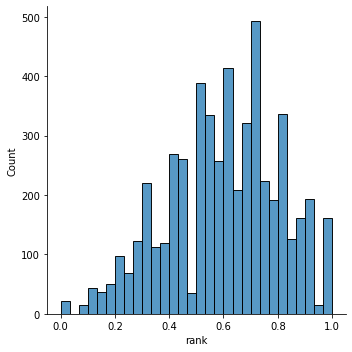

In [5]:
sns.displot(ibm, x="rank")

# Functions for step-wise regression and feature reassignment

In [5]:
# Forward selection function for linear models
def forward_selection(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    r_vals = []
    sign = []
    current_score, best_new_score = float('0'), float('0')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response,
                                        ' + '.join(selected + [candidate]))
            score = ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates.pop(0)
        if current_score < best_new_score:
            if len(selected):
                old_model = current_model
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_model = ols(f"{response} ~ {' + '.join(selected)}", data).fit()
            r_vals.append(current_model.rsquared_adj)
            if len(sign):
                table = anova_lm(old_model, current_model)
                sign.append(table["Pr(>F)"][1])
            else:
                sign.append("x")
            current_score = best_new_score
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    model = ols(formula, data).fit()
    return {"model": model, "remaining": remaining, "r2": r_vals, "significance":  sign}

In [ ]:
# Forward selection function for linear models
def poly_forward_selection(data, response):
    remaining = set(data.columns)
    remaining.remove(response)
    ########
    interactions = set()
    for i in remaining:
        for j in remaining:
            if i != j and j+":"+i not in remaining:
                interactions.add(i+":"+j)
    remaining.update(interactions)
    ########
    selected = []
    r_vals = []
    sign = []
    current_score, best_new_score = float('inf'), float('inf')  # float('0'), float('0')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response,
                                        ' + '.join(selected + [candidate]))
            score = ols(formula, data).fit().aic  # rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()  # reverse=True)
        best_new_score, best_candidate = scores_with_candidates.pop(0)
        if (current_score - best_new_score) >=1:
            if len(selected):
                old_model = current_model
                current_model = ols(f"{response} ~ {' + '.join(selected+[best_candidate])}", data).fit()
                table = anova_lm(old_model, current_model)
                sign.append(table["Pr(>F)"][1])
                r_vals.append(current_model.rsquared_adj)
                if sign[-1] < 0.05:
                    remaining.remove(best_candidate)
                    selected.append(best_candidate)
                    current_score = best_new_score
            else:
                current_model = ols(f"{response} ~ {best_candidate}", data).fit()
                sign.append("x")
                r_vals.append(current_model.rsquared_adj)
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    model = ols(formula, data).fit()
    return {"model": model, "remaining": remaining, "r2": r_vals, "significance":  sign}

In [7]:
def feature(x):
    feat = ""
    if x[2] == "prob":
        feat += "prob_"
    feat += x[0]
    if x[1] == "masked":
        feat += "_masked"
    elif x[1] == "orig":
        feat += "_unmasked"
    else: feat += "_" + x[1]
    return feat

# def re_feats(x):
#     out = ""
#     if ":" in x:
#         x1, x2 = x.split(":")
#         out = re_feats(x1) + " : " + re_feats(x2)
#         return out
#     x = x.split("_")
#     if x[0] == "prob":
#         out += ", p)"
#         x.pop(0)
#     else:
#         out += ", d)"
#     if x[-1] == "masked":
#         out = " (m" + out
#         x.pop(-1)
#     else:
#         out = " (o" + out
#         x.pop(-1)
#     if len(x)>1:
#         out = "/shame" + out
#     out = x[0].title() + out
#     return out

def re_feats(x):
    out = ""
    if ":" in x:
        x1, x2 = x.split(":")
        out = re_feats(x1) + " : " + re_feats(x2)
        return out
    x = x.split("_")
    if "guilt" in x:
        return "guilt/shame"
    elif "storytelling" in x:
        return "storytelling"
    elif "hedge" in x:
        if "avg" in x:
            return "avg(all hedge)"
        elif "abs" not in x:
            return f"avg({x[0]} hedge)"
        elif "global" in x:
            return "all hedge"
        else:
            return x[0] + " hedge"
    else:
        if x[0] == "prob":
            return x[1]
        else: return x[0]


# Individual Feature Regression
Each of the following models will have just one independent variable, sorted by variable type: 
1. Emotion
    - Bivariate/simple regression with all emotion variants
    - Determining best variant for each emotion
    - Multilinear stepwise regression -> building most informative emotion model
    - Polynomial stepwise regression -> finding interesting emotion interactions
2. Storytelling
    - Bivariate regression with all storytelling variants
    - Determining best variant for storytelling (mixed/one training, discreet/prob annotation)
3. Hedging
    - Bivariate/simple regression with all hedging variants
    - Determining best variant for each hedging score (avg or abs)
    - Multilinear stepwise regression -> building most informative emotion model
    - Polynomial stepwise regression -> finding interesting emotion interactions

In sections (1) and (2), the LR uses the discreet/binary values from the classifier and not the probability outputs and section (4) consists of a model that includes independent variables from all three features, choosing the feature variant that is most informative for the regression (highest R<sup>2</sup>).

**ATTENTION** - p-value significance levels are 0.05 (*), 0.01 (\*\*), 0.001 (\*\*\*)

# 1. Emotions
The possible variants here are the features predicted by the classifier using data with masked emotion words or unmasked texts:

## 1.1 Simple linear regression

In [8]:
all_emo = sorted(emotion_orig[:-2] + emotion_masked[:-2]) + sorted(emotion_orig_prob + emotion_masked_prob)

simple_results = {emo[:-9]: {} for emo in emotion_orig[:-2]}
for k in simple_results:
    simple_results[k] = {"orig": {"discreet":{}, "prob": {}}, "masked": {"discreet":{}, "prob": {}}}
masked_results = {emo[:-9]: {} for emo in emotion_orig[:-2]}
for v in emotion_masked_prob:#all_emo:
    ibm_formula = f"rank ~ {v}"

    print("==============================================================================", "\n", "IV: ", v, sep="")
    ibm_results = ols(ibm_formula, ibm).fit()
    # emo = v.split("_")
    # if "prob" in v:
    #     emo = "_".join(v.split("_")[1:-1])
    #     if "unmasked" in v:
    #         simple_results[emo]["orig"]["prob"] = {"r2": ibm_results.rsquared_adj, "beta": ibm_results.params[v], "p": ibm_results.pvalues[v]}
    #     else:
    #         simple_results[emo]["masked"]["prob"] = {"r2": ibm_results.rsquared_adj, "beta": ibm_results.params[v], "p": ibm_results.pvalues[v]}
    # else: 
    #     emo = "_".join(v.split("_")[:-1])
    #     if "unmasked" in v:
    #         simple_results[emo]["orig"]["discreet"] = {"r2": ibm_results.rsquared_adj, "beta": ibm_results.params[v], "p": ibm_results.pvalues[v]}
    #     else:
    #         simple_results[emo]["masked"]["discreet"] = {"r2": ibm_results.rsquared_adj, "beta": ibm_results.params[v], "p": ibm_results.pvalues[v]}
    print("Adjusted r2:", ibm_results.rsquared_adj, "\tp-value:", ibm_results.pvalues[1])
    masked_results[v[5:-7]] = {"r2": ibm_results.rsquared_adj, "p": ibm_results.pvalues[v], "beta": ibm_results.params[v]}

masked_results = pd.DataFrame(masked_results).transpose()
print(masked_results.to_latex(float_format="%.4f"))


IV: prob_anger_masked
Adjusted r2: 0.00111598583217154 	p-value: 0.008558018631802913
IV: prob_boredom_masked
Adjusted r2: 0.0005911586098031885 	p-value: 0.042099056452570026
IV: prob_disgust_masked
Adjusted r2: 0.0021795403149095227 	p-value: 0.00039532454296362004
IV: prob_fear_masked
Adjusted r2: 0.002614025132131048 	p-value: 0.00011576149653278382
IV: prob_guilt_shame_masked
Adjusted r2: 0.009707535033014358 	p-value: 3.971506631064661e-13
IV: prob_joy_masked
Adjusted r2: 0.006458197395129761 	p-value: 2.8116892774433985e-09
IV: prob_pride_masked
Adjusted r2: 0.0003490368685472589 	p-value: 0.09146158808721679
IV: prob_relief_masked
Adjusted r2: 0.0007928155053735786 	p-value: 0.022589085409816037
IV: prob_sadness_masked
Adjusted r2: 0.0006874575291395679 	p-value: 0.03120781403603079
\begin{tabular}{lrrr}
\toprule
 & r2 & p & beta \\
\midrule
anger & 0.0011 & 0.0086 & -0.0262 \\
disgust & 0.0022 & 0.0004 & -0.0312 \\
fear & 0.0026 & 0.0001 & 0.0558 \\
guilt_shame & 0.0097 & 0.00

### 1.1.1 Best Variant for each Emotion

The regression results, i.e., R<sup>2</sup> and p-Value, are compared for all variants of one emotion class to determine the best feature variant for following, more complex models

In [10]:
best = []
for emo in simple_results:
    ibm_best = []
    for var in simple_results[emo]:
        for anno in simple_results[emo][var]:
            ibm_best.append((emo, var, anno, simple_results[emo][var][anno]["p"], simple_results[emo][var][anno]["r2"]))
    ibm_best.sort(key= lambda x: x[-1], reverse=True)
    if ibm_best[0][-1] == 0:
        ibm_best.sort(key= lambda x: x[-2])
    best.append(ibm_best[0])

vars = {"orig": 0, "masked": 0, "discreet": 0, "prob": 0}
for i in best:
    vars[i[1]] += 1
    vars[i[2]] += 1
print(vars)

best = sorted(best, key=lambda x: x[-1], reverse=True)
best

KeyError: 'p'

In [70]:
simple_results["relief"]

{'orig': {'discreet': {'r2': -6.617181724299925e-05,
   'beta': 0.032145329362338326,
   'p': 0.42032372126583006},
  'prob': {'r2': 0.0007747315863959603,
   'beta': 0.0786490177169848,
   'p': 0.02387084003872101}},
 'masked': {'discreet': {'r2': 0.0018949444407464489,
   'beta': 0.08636350441662169,
   'p': 0.0008897423515839468},
  'prob': {'r2': 0.0007928155053735786,
   'beta': 0.062827263882543,
   'p': 0.022589085409816037}}}

### 1.1.2 Emotion comparison masked/unmasked

In [29]:
# all_emo = sorted(emotion_orig_whole+emotion_probs_orig_whole+emotion_masked_whole+emotion_probs_masked_whole)
whole_results = {emo: {} for emo in sorted(emotion_masked+emotion_orig)}
for k in whole_results:
    whole_results[k] = {"disc_r2":0, "prob_r2": 0, "disc_p":0, "prob_p": 0}
masked_results = {emo[:-7]: {} for emo in emotion_masked[:-2]}

for v in all_emo:
    formula = f"rank ~ {v}"

    # print("==============================================================================", "\n", "IV: ", v, sep="")
    results = ols(formula, ibm).fit()
    var_labels = v.split("_")
    if "unmasked" in var_labels:
        train = "unmasked"
    else:
        train = "masked"
    if "prob" in var_labels:
        anno = "prob"
        emo = var_labels[1]
        if emo == "guilt":
            emo += "_shame"
    else:
        anno = "disc"
        emo = var_labels[0]
        if emo == "guilt":
            emo += "_shame"
    whole_results[emo+"_"+train][anno+"_r2"] = results.rsquared_adj
    whole_results[emo+"_"+train][anno+"_p"] =  results.pvalues[v]
    if train == "masked" and anno == "prob":
        masked_results[emo] = {"\\textbf{\\textit{r}\\textsuperscript{2}}": results.rsquared_adj, "\\textbf{p-Value}": results.pvalues[v], "\\textbf{Coef}": results.params[v]}
    # print(results.summary())
whole_results=pd.DataFrame(whole_results).transpose()
whole_results

masked_results = pd.DataFrame(masked_results).transpose()
better_disc = whole_results.loc[whole_results["disc_r2"]>whole_results["prob_r2"]]
print(masked_results.to_latex(float_format="%.4f"))

\begin{tabular}{lrrr}
\toprule
 & \textbf{\textit{r}\textsuperscript{2}} & \textbf{p-Value} & \textbf{Coef} \\
\midrule
anger & 0.0011 & 0.0086 & -0.0262 \\
disgust & 0.0022 & 0.0004 & -0.0312 \\
fear & 0.0026 & 0.0001 & 0.0558 \\
guilt_shame & 0.0097 & 0.0000 & -0.1391 \\
joy & 0.0065 & 0.0000 & 0.1731 \\
pride & 0.0003 & 0.0915 & 0.0367 \\
relief & 0.0008 & 0.0226 & 0.0628 \\
sadness & 0.0007 & 0.0312 & 0.0440 \\
trust & NaN & NaN & NaN \\
\bottomrule
\end{tabular}



In [12]:
better_disc

,disc_r2,prob_r2,disc_p,prob_p
pride_masked,0.000437,0.000349,0.068695,0.091462
relief_masked,0.001895,0.000793,0.000890,0.022589


### Emotion labels from classifier trained with original texts
The results show that many of the features have no measurable effect on argument strength, as they cannot explain the variance in the data (R<sup>2</sup>=0), these features include _anger_, _boredom_, _fear_, _pride_, _relief_, _sadness_, _surprise_, and _emotionality_. Features that do explain part of the variance also have very small R<sup>2</sup> values, these include _trust_ (0.003, adjusted 0.002), negative _sentiment_ (0.002), _disgust_ (0.001), _guilt/shame_ (0.001), positive _sentiment_ (0.001), and _joy_ (0.001, though no effect after adjusting R<sup>2</sup>).

_Trust_ and _negative sentiment_ thus explain the most variance in the data, with trust having a positive highly significant (p=.001) and negative sentiment a negative significant (p=.002) effect. We can thus extrapolate that negativity lowers the argument quality while displaying trust leads to higher argument quality. Both coefficients are very small, which is partly due to the interplay of the binary IV and very small DV, as the coefficient of each independent variable is only ever turned on or off (1/0 feature manifestation) but influences a dependent variable that is always between 0 and 1. Given this problem, the high significance of the effects weighs more than the low effect size.

Interesting however is that the most frequent emotion _disgust_ only explains .1% of variance and like the second most frequent emotion _anger_ has no significant influence on argument quality. This may be due to low classification performance, as the in-domain evaluation for _anger_ showed f<sub>1</sub> scores between .6 and .7 for the positive class with low precision. Such in-domain results indicate that the cross-domain deployment on the argument data might lead to overprediction of the emotion and might thus hinder finding meaningful patterns in the data.

### Emotion probabilities from classifier trained with original texts
In contrast to the binary emotion labels that had many features explaining no variance at all, the emotion probabilities (non-discretized classifier outputs) explain much more of the variance, with some emotions explaining almost 1%. The emotions having a measurable effect on the argument quality include in order of most informative: _guilt/shame_ (negative, R=.009, \*\*\*), _trust_ (positive, adj. R=.008, \*\*\*), _joy_ (positive, R=.003, \*\*\*), _anger_ (negative, R=.003, \*\*\*), _boredom_ (negative, R=.002, \*\*), _surprise_ (negative, R=.002, \*\*), _relief_ (positive, adj. R=.001, \*\*), disgust (negative, adj. R=.001, \*), and _fear_ (positive, R=.001, \*). Only _sadness_, _pride_ and the overall _emotionality_ have no effect on the argument quality. 

This result is interesting especially in comparing the different emotion polarities; _guilt/shame_ has the highest impact in lowering the argument quality and _trust_ has an almost identical impact raising the argument quality. Thus, the IBM data seems to show that guilt based argumentation does not work persuasively and instead arguments that display trust do. In general, we can see that almost all negative emotions have a negative effect on argument quality and vice versa for positive emotions with two notable exceptions: While _fear_ only explains .1% of the argument quality variance, it has a significantly (\*) positive effect, showing that fearful arguments are more persuasive. _Surprise_ on the other hand has a significantly (\*\*) negative effect explaining .2% of variance, though this might not show the adverse effect of showing surprise in argumentation but rather be a residual of the emotion being very low overall in the data (when discretizing the probabilities, surprise is not included in the IBM data).

_Sadness_ and _pride_ have no measurable effect on the data (**TODO:** look at std of classification results). The last feature that is also non-explanatory is the aggregated emotionality of the argument, which might mostly be due to the abstractness of the feature (sum of all emotion probabilities) that hinders informativity.

### Emotion labels from classifier trained with original texts
Of all 14 masked emotion features, only 7 have non-nil R<sup>2</sup> values, those are in order of most explained variance: _trust_ (0.004), _relief_ (0.003), positive _sentiment_ (0.002), _pride_ (0.002, adjusted 0.001), negative _sentiment_ (0.002, adjusted 0.001), _disgust_ (0.001) and _guilt/shame_ (0.001). These are however more than in the unmasked feature variant, where after adjusting the R<sup>2</sup> only 5 features measurably explain some of the argument quality variance. The emotion features that do not explain any variance are _anger_, _boredom_, _fear_, _sadness_, _joy_, _surprise_, and _emotionality_. This is in line with the unmasked results, though the explanatory masked features generally explain more variance than their unmasked counterparts and include more effects of (high) significance.

Especially interesting is the positive effect of _positive sentiment_, which is significant (p=0.003, \*\*) unlike the masked significant effect (p=0.024, \*). The same but inverted observation holds for the _negative sentiment_, which has a negative effect for both masked and unmasked features, but is highly significant for the masked (p=0.002, \*\*) and significant (p=0.012, \*) for unmasked emotions.

### Emotion probabilities from classifier trained with original texts
Of all 14 masked emotion features, only 7 have non-nil R<sup>2</sup> values, those are in order of most explained variance: _trust_ (0.004), _relief_ (0.003), positive _sentiment_ (0.002), _pride_ (0.002, adjusted 0.001), negative _sentiment_ (0.002, adjusted 0.001), _disgust_ (0.001) and _guilt/shame_ (0.001). These are however more than in the unmasked feature variant, where after adjusting the R<sup>2</sup> only 5 features measurably explain some of the argument quality variance. The emotion features that do not explain any variance are _anger_, _boredom_, _fear_, _sadness_, _joy_, _surprise_, and _emotionality_. This is in line with the unmasked results, though the explanatory masked features generally explain more variance than their unmasked counterparts and include more effects of (high) significance.

Especially interesting is the positive effect of _positive sentiment_, which is significant (p=0.003, \*\*) unlike the masked significant effect (p=0.024, \*). The same but inverted observation holds for the _negative sentiment_, which has a negative effect for both masked and unmasked features, but is highly significant for the masked (p=0.002, \*\*) and significant (p=0.012, \*) for unmasked emotions.

## 1.2 Multilinear regression

This model uses all previously determined best emotion feature variants in a step-wise multilinear regression without interaction. 

In [30]:
cols = [feature(x) for x in best]
cols += ["rank"]
cols

['rank']

In [31]:
data = ibm[emotion_masked_prob+["rank"]]

# Using forward selection function to calculate best features
multi_result = forward_selection(data, 'rank')
model = multi_result["model"]
remaining = multi_result["remaining"]
sign = multi_result["significance"]
r2 = list(map(lambda x: x*100, multi_result["r2"]))
print(model.model.formula)
print(model.summary())
print(remaining)
names = map(re_feats,list(model.params.index)[1:len(r2)+1])
r_list = pd.DataFrame(list(zip(names, r2, sign)), columns=("Emotion", "\\textbf{\\textit{r}\\textsuperscript{2}}", "\\textbf{p-Value}"))
print(r_list.to_latex(float_format="%.3f"))

rank ~ prob_guilt_shame_masked + prob_fear_masked + prob_joy_masked + prob_sadness_masked + prob_disgust_masked + prob_relief_masked + prob_pride_masked
                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     20.17
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           6.68e-27
Time:                        16:09:48   Log-Likelihood:                 904.47
No. Observations:                5298   AIC:                            -1793.
Df Residuals:                    5290   BIC:                            -1740.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t 

This multilinear emotion model without interaction explains 4.1% of argument quality variance with only one insignificant effect ( _anger_), and two emotions that did not improve the model at all (_pride_, _boredom_). These latter two were already not very informative in a simple regression, though notable changes in effect size and direction include the change in effect direction for _fear_ and _disgust_, which alone had negative effects but now influence argument quality positively.
<!-- , which might however be due to the big negative effect of _surprise_ and _guilt/shame_ that already include any negative effects that fear or disgust might hold. -->

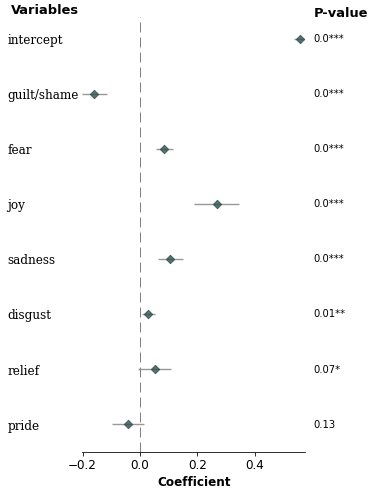

In [32]:
params = model.params
conf = model.conf_int()
conf['Effect'] = params
conf.columns = ['5%', '95%', 'Effect']
conf["Variables"] = [list(params.index)[0].lower()] + [re_feats(x) for x in list(params.index)[1:]]
conf["P-value"] = model.pvalues

fp.forestplot(conf,  # the dataframe with results data
              estimate="Effect",  # col containing estimated effect size 
              ll="5%", hl="95%",  # columns containing conf. int. lower and higher limits
              varlabel="Variables",  # column containing variable label
              ylabel="Variables",  # y-label title
              xlabel="Coefficient",  # x-label title
              pval="P-value",  # column containing p-values
              ci_report=False,  # Turn off conf. int. reporting
              # xticks=[-.5,-.25,0,.25,.5],  # x-ticks to be printed
              # table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                 'fontfamily': 'serif'  # revert to sans-serif
                } 
              )

plt.savefig("img/ibm_emo_forestplot.svg", bbox_inches="tight", format="svg")

## 1.3 Polynomial multilinear regression

The following model uses all unmasked emotion features as above, but includes pairwise interaction between the variables. 

In [33]:
best_cols = emotion_masked_prob + ["rank"]
data = ibm[best_cols]

# Using forward selection function to calculate best features
inter_result = poly_forward_selection(data, 'rank')
inter_model = inter_result["model"]
inter_remaining = inter_result["remaining"]
inter_sign = inter_result["significance"]
inter_r2 = inter_result["r2"]
print(inter_model.model.formula)
print(inter_model.summary())
print(inter_remaining)
list(zip(inter_r2, inter_sign))

rank ~ prob_guilt_shame_masked + prob_disgust_masked:prob_fear_masked + prob_joy_masked + prob_sadness_masked + prob_pride_masked:prob_sadness_masked + prob_pride_masked:prob_relief_masked + prob_anger_masked:prob_relief_masked + prob_disgust_masked:prob_relief_masked
                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     21.49
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           1.81e-32
Time:                        16:10:05   Log-Likelihood:                 919.42
No. Observations:                5298   AIC:                            -1821.
Df Residuals:                    5289   BIC:                            -1762.
Df Model:                           8                                         
Covariance Type:    

[(np.float64(0.009707535033014358), 'x'),
 (np.float64(0.01529467293223219), np.float64(2.6401664741295193e-08)),
 (np.float64(0.02093925556523024), np.float64(2.066751293886455e-08)),
 (np.float64(0.025220467506920086), np.float64(8.712724044755119e-07)),
 (np.float64(0.026492719908893902), np.float64(0.0049145264312812015)),
 (np.float64(0.028053705615363023), np.float64(0.0020662230709078988)),
 (np.float64(0.028899807513671938), np.float64(0.01789448583323007)),
 (np.float64(0.030019336158689902), np.float64(0.007707739810627472)),
 (np.float64(0.03053348719212623), np.float64(0.051152804012080444))]

0.030019336158689902


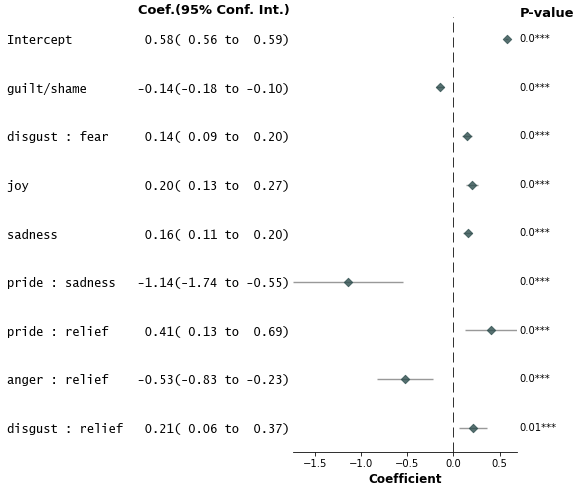

In [35]:
params = inter_model.params
conf = inter_model.conf_int()
conf['Effect'] = params
conf.columns = ['5%', '95%', 'Effect']
conf["Variables"] = [list(params.index)[0]] + [re_feats(x) for x in list(params.index)[1:]]
conf["P-value"] = inter_model.pvalues

tmp = {'5%': [], '95%': [], 'Effect': [], "Variables": [], "P-value": []}
for i, row in conf.iterrows():
    if row["P-value"] < 0.05:
        for c in conf.columns:
            tmp[c].append(row[c])

new_conf = pd.DataFrame(tmp)
plot = fp.forestplot(new_conf,  # the dataframe with results data
              estimate="Effect",  # col containing estimated effect size 
              ll="5%", hl="95%",  # columns containing conf. int. lower and higher limits
              varlabel="Variables",  # column containing variable label
              ylabel="Coef.(95% Conf. Int.)",  # y-label title
              xlabel="Coefficient",  # x-label title
              pval="P-value",  # column containing p-values
              ci_report=True,  # Turn off conf. int. reporting
              # sort=True,  # sort in ascending order (sorts within group if group is specified)
              return_df=True,  # ff True, returned the preprocessed dataframe.
              # xticks=[-1,-.5,0,.5, 1],  # x-ticks to be printed
              # table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                #  "xlinecolor": "#808080",  # gray color for x-reference line
                #  "xtick_size": 12,  # adjust x-ticker fontsize
                #  'fontfamily': 'serif'  # revert to sans-serif
                } 
              )

print(inter_model.rsquared_adj)
d = new_conf.copy(deep=True)
d.set_index("Variables", inplace=True)
d["P-value"] = round(d["P-value"],5)
d["P-value"]
# plot[0]

plt.savefig("img/ibm_inter_emo_forestplot.svg", bbox_inches="tight", format="svg")

While the model with two-way interaction explains 6,2% of the variance in argument quality and thus explains more than any of the non-polynomial models, some individual emotion features lose significance and many interactions are insignificant as well.

The emotions without individual significance are _guilt/shame_, _surprise_, _sadness_, _joy_, _boredom_, _disgust_, _pride_, and _relief_ loses significance both individually and in any interactions. Notable interactions are the big negative effect of guilt and surprise together and the general trend for many negative effects including positive emotions like _pride_ and _trust_. Similarly, there are multiple interactions with negative emotions with a positive effect, including _sadness_, _disgust_ and _anger_, which have negative effects in a simple model but positive effects as soon as other emotions are introduced.
<!-- While the model explains 1.4% (adjusted .8) of the variance in argument quality and thus explains more than any of the non-polynomial models, none of the coefficients are significant. Especially interesting is the fact that the previous most informative feature of _negative sentiment_ is no longer significant (p=0.159), and is also not included in any of the interactions with bigger effects. These interaction effects that approach significance include namely negative effects for the interactions _pride:trust_ (p=0.075) and _boredom:pride_ (p=0.079), and positive effects for _boredom:relief_ (p=0.076) and _anger:positive_ (p=0.079). 

As _trust_ had a positive effect in its own, this and the individual negative trust coefficient in this polynomial model is an interesting diversion. Similarly, both relief and boredom individually have negative effects but seem to improve arguments when combined. -->

# 2. Storytelling


In [36]:
all_story = storytelling + storytelling_prob
story_results = {"mixed_domain": {"discreet":{}, "prob": {}}, "one_domain": {"discreet":{}, "prob": {}}}

for v in all_story:
    formula = f"rank ~ {v}"

    print("==============================================================================", "\n", "IV: ", v, sep="")
    result = ols(formula, ibm).fit()
    story = v.split("_")
    if "prob" in v:
        if "one" in v:
            story_results["one_domain"]["prob"] = {"r2": result.rsquared_adj, "beta": result.params[v], "p": result.pvalues[v]}
        else:
            story_results["mixed_domain"]["prob"] = {"r2": result.rsquared_adj, "beta": result.params[v], "p": result.pvalues[v]}
    else: 
        if "one" in v:
            story_results["one_domain"]["discreet"] = {"r2": result.rsquared_adj, "beta": result.params[v], "p": result.pvalues[v]}
        else:
            story_results["mixed_domain"]["discreet"] = {"r2": result.rsquared_adj, "beta": result.params[v], "p": result.pvalues[v]}
    print(result.summary())

story_res = {"r2":{}, "beta": {}, "p": {}}
for dom in story_results:
    for anno in story_results[dom]:
        for stat in story_results[dom][anno]:
            story_res[stat][dom+"/"+anno] = story_results[dom][anno][stat]
story_res = pd.DataFrame(story_res).sort_values(by="r2")
story_res

IV: storytelling_mixed_domain
                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     23.15
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           1.54e-06
Time:                        16:10:49   Log-Likelihood:                 846.23
No. Observations:                5298   AIC:                            -1688.
Df Residuals:                    5296   BIC:                            -1675.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

,r2,beta,p
mixed_domain/discreet,0.004164,-0.148593,1.539974e-06
one_domain/discreet,0.004521,-0.152892,5.744031e-07
mixed_domain/prob,0.004703,-0.182112,3.483885e-07
one_domain/prob,0.007366,-0.228901,2.352659e-10


In [37]:
str(story_res["p"]["mixed_domain/discreet"])

'1.5399743152291425e-06'

### Review of feature variants
Another interesting observation is the highly significant (p=0.0, \*\*\*) _negative_ effect (c=-.139) of storytelling. This feature explains as much variance as the most explanatory emotion feature (R<sup>2</sup>=.004). 
<!-- Depending on the results for CMV, t -->
This might suggest that the IBM data's preoccupation with professional debate speeches leads to arguments leaning on more personal anecdotes being judged as less good.

When using discreet labels, the choice of training data does not seem to make as much of a difference for storytelling as for the emotions. The adjusted R<sup>2</sup> is almost identical for both variants (0.004), and the coefficient is very similar (-0.149 / -0.153 / \*\*\*). The probability annotation however has a big jump both in explanatory power and effect, where the _one-domain_ annotation clearly surpasses all other variants in adjusted R<sup>2</sup> (0.007) and coefficient size (-0.23).

The choice of training data does not seem to make as much of a difference for storytelling as for the emotions. The R<sup>2</sup> is the same for both variants after adjustment, and the coefficient is very similar (-0.138 / -0.148 / \*\*\*).

# 3. Hedging

The independent variables used in the following models are the absolute count and ratio of hedge words for the first, last and all sentences

In [72]:
hedging

['first_abs_hedge',
 'first_hedge',
 'final_abs_hedge',
 'final_hedge',
 'global_abs_hedge',
 'avg_hedge']

## 3.1 Bivariate linear regression

In [38]:
hedge_results = {"final": {"abs": {}, "avg": {}}, "first": {"abs": {}, "avg": {}}, "global": {"abs": {}, "avg": {}}}
for v in hedging:
    formula = f"rank ~ {v}"

    print("==============================================================================", "\n", "IV: ", v, sep="")
    result = ols(formula, ibm).fit()
    hedge = v.split("_")
    if "final" in hedge:
        if "abs" in hedge:
            hedge_results["final"]["abs"] = {"r2": result.rsquared_adj, "beta": result.params[v], "p": result.pvalues[v]}
        else:
            hedge_results["final"]["avg"] = {"r2": result.rsquared_adj, "beta": result.params[v], "p": result.pvalues[v]}
    elif "first" in hedge:
        if "abs" in hedge:
            hedge_results["first"]["abs"] = {"r2": result.rsquared_adj, "beta": result.params[v], "p": result.pvalues[v]}
        else:
            hedge_results["first"]["avg"] = {"r2": result.rsquared_adj, "beta": result.params[v], "p": result.pvalues[v]}
    elif "global" in hedge:
        hedge_results["global"]["abs"] = {"r2": result.rsquared_adj, "beta": result.params[v], "p": result.pvalues[v]}
    else:
        hedge_results["global"]["avg"] = {"r2": result.rsquared_adj, "beta": result.params[v], "p": result.pvalues[v]}
    print(result.summary())

h_res = {"r2":{}, "beta": {}, "p": {}}
for sent in hedge_results:
    for score in hedge_results[sent]:
        for stat in hedge_results[sent][score]:
            h_res[stat][sent+"/"+score] = hedge_results[sent][score][stat]
h_res = pd.DataFrame(h_res).sort_values(by="r2")
h_res

IV: first_abs_hedge
                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     24.60
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           7.29e-07
Time:                        16:10:57   Log-Likelihood:                 846.95
No. Observations:                5298   AIC:                            -1690.
Df Residuals:                    5296   BIC:                            -1677.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.

,r2,beta,p
final/abs,-0.000185,0.000505,8.936306e-01
final/avg,0.000742,-0.158942,2.638531e-02
global/abs,0.002707,-0.011175,8.918389e-05
first/avg,0.003595,-0.159723,7.468198e-06
global/avg,0.003608,-0.296443,7.193497e-06
first/abs,0.004435,-0.029510,7.289914e-07


The informative hedging features include the first sentence's absolute number (R<sup>2</sup>=.004) and ratio (R<sup>2</sup>=.003) of hedge words, the averaged hedge ratio of all sentences (R<sup>2</sup>=.003), and the overall number of hedge words (R<sup>2</sup>=.001, \*\*). All coefficients are negative and (highly) significant, paired with a positive highly significant intercept. This is interesting insofar as most arguments in the IBM dataset repeat the stance given at argument generation in the first sentence, to then include the actual generated argument in the later sentences. As the absolute and averaged number of hedges in the final sentence do not explain any variance in the argument quality scores but have positive coefficients, this result might show a simple regression on the argument topics or stances, many of which include "should", overestimating argument quality through the intercept and mitigating this for topics that have overall less qualitative arguments.

In [39]:
hedge_res = {"r2":{}, "beta": {}, "p": {}}
for sent in hedge_results:
    for anno in hedge_results[sent]:
        for stat in hedge_results[sent][anno]:
            hedge_res[stat][sent+"/"+anno] = hedge_results[sent][anno][stat]
hedge_res = pd.DataFrame(hedge_res).sort_values(by="r2")
hedge_res

,r2,beta,p
final/abs,-0.000185,0.000505,8.936306e-01
final/avg,0.000742,-0.158942,2.638531e-02
global/abs,0.002707,-0.011175,8.918389e-05
first/avg,0.003595,-0.159723,7.468198e-06
global/avg,0.003608,-0.296443,7.193497e-06
first/abs,0.004435,-0.029510,7.289914e-07


## 3.2 Multilinear regression

In [40]:
v = [
    # 'avg_hedge',
    # 'final_abs_hedge',
    'final_hedge',
    'first_abs_hedge',
    # 'first_hedge',
    # 'global_abs_hedge',
    'rank',
     ]
data = ibm[v]

# Using forward selection function to calculate best hedging features
multi_hedge_result = forward_selection(data, 'rank')
multi_hedge_model = multi_hedge_result["model"]
multi_hedge_remaining = multi_hedge_result["remaining"]
multi_hedge_sign = multi_hedge_result["significance"]
multi_hedge_r2 = multi_hedge_result["r2"]
print(multi_hedge_model.model.formula)
print(multi_hedge_model.summary())
print("Unused hedging features:", ", ".join(multi_hedge_remaining))
print ("R^2   ", "Pr(>F)")
z = []
for x in zip(multi_hedge_r2, multi_hedge_sign):
    e = str(round(x[0],4))
    if x[1] == "x":
        z.append((e,x[1]))
    else:
        f = str(round(x[1],7))
        z.append((e,f))
print("\n".join([" ".join(x) for x in z]))

rank ~ first_abs_hedge + final_hedge
                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     14.02
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           8.46e-07
Time:                        16:11:15   Log-Likelihood:                 848.67
No. Observations:                5298   AIC:                            -1691.
Df Residuals:                    5295   BIC:                            -1672.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Inter

<!-- Unlike the bivariate experiments, when including hedge scores from multiple instance parts, the unexpected behavior of the first sentence's effect is gone (p=.69 and p=.73) and instead the two features measuring hedging in the final sentence explain most of the variance (adj. R<sup>2</sup>=.008) with the absolute number having a highly significant positive effect and the ratio of hedge words a significant negative effect. The negative effect of the absolute number of overall hedge words is also significant (p=.034, \*) -->
Multilinear regression is only more informative when combining the final sentence's averaged score with either score of the first sentence - These improvements in explained variance are not significant however, unless a third variant for the whole instance is also used. This however introduces multicolinearity and in some combinations still removes the final sentence from the multilinear model.

### 3.2.1 Hedging Multicolinearity

In [41]:
h = ibm[['final_abs_hedge', 'first_abs_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = ibm[['final_abs_hedge', 'final_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = ibm[['first_abs_hedge', 'first_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns 
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = ibm[['avg_hedge','global_abs_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = ibm[['final_abs_hedge','first_abs_hedge','global_abs_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

h = ibm[['final_abs_hedge','first_abs_hedge','avg_hedge']]
vif_data = pd.DataFrame() 
vif_data["feature"] = h.columns
vif_data["VIF"] = [variance_inflation_factor(h.values, i) for i in range(len(h.columns))]
print(vif_data, "\n")

           feature       VIF
0  final_abs_hedge  1.401672
1  first_abs_hedge  1.401672 

           feature       VIF
0  final_abs_hedge  5.219006
1      final_hedge  5.219006 

           feature        VIF
0  first_abs_hedge  22.737376
1      first_hedge  22.737376 

            feature      VIF
0         avg_hedge  6.18298
1  global_abs_hedge  6.18298 

            feature        VIF
0   final_abs_hedge   7.125963
1   first_abs_hedge   6.507805
2  global_abs_hedge  17.618703 

           feature        VIF
0  final_abs_hedge   2.667653
1  first_abs_hedge  11.841770
2        avg_hedge  16.598398 



While there is no multicolinearity between the first and final sentence's hedge features (VIF =1.402), the absolute and averaged features of the same span (first, final, all sentences) are highly correlated as they are calculated from the same base hedge counts and the global hedge counts and averages are similarly correlated with the features of the individual sentences. 

## 3.3 Polynomial multilinear regression

In [42]:
h = [
    'avg_hedge',
    'final_abs_hedge',
    # 'final_hedge',
    'first_abs_hedge',
    # 'first_hedge',
    # 'global_abs_hedge',
    "rank"
    ]
poly_hedge_result = poly_forward_selection(ibm[h], "rank")
poly_hedge_model = poly_hedge_result["model"]
poly_hedge_remaining = poly_hedge_result["remaining"]
poly_hedge_sign = poly_hedge_result["significance"]
poly_hedge_r2 = poly_hedge_result["r2"]
print(poly_hedge_model.model.formula)
print(poly_hedge_model.summary())
print(poly_hedge_remaining)
list(zip(poly_hedge_r2, poly_hedge_sign))
# formula = "rank ~ (" + " + ".join(h) + ")**2"

# interact = ols(formula, ibm).fit()
# print("==============================================================================", "\n", "IV: hedging scores", sep="")
# print(interact.summary())

rank ~ first_abs_hedge
                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     24.60
Date:                Wed, 19 Mar 2025   Prob (F-statistic):           7.29e-07
Time:                        16:11:24   Log-Likelihood:                 846.95
No. Observations:                5298   AIC:                            -1690.
Df Residuals:                    5296   BIC:                            -1677.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          

[(np.float64(0.004434876233015861), 'x')]

The hedging analysis with interaction explains most variance of all hedging models, but changes which individual features are most informative. The positive effect of the number of hedges in the final sentence is lowered (p=.022 \*), while the negative effect of the first sentence reemerges (p=.00 \*\*\*). The interaction between number of hedges in the final sentence and overall ratio of hedges is also significant (p=.003 \*\*) and the only insignificant features are the overall average number of hedges (p=.056) and its interaction with the number of hedges in the first sentence (p=.129).

# Plotting effects and interactions

In [44]:
results = ols(ibm, "rank ~ first_abs_hedge + prob_storytelling_mixed_domain + prob_pride_masked").fit()
fig = sm.graphics.plot_partregress_grid(results)
plt.rc("figure", figsize=(16, 8))
# plt.rc("font", size=14)
fig.tight_layout(pad=1.0)

PatsyError: model is missing required outcome variables

## Validity of Results

### No Multicolinearity

In [45]:
vif = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=x_train.columns).T

NameError: name 'x_train' is not defined

### Normality of Residuals

<ipython-input-9-a8d85ebbc716>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual)


<Axes: ylabel='Density'>

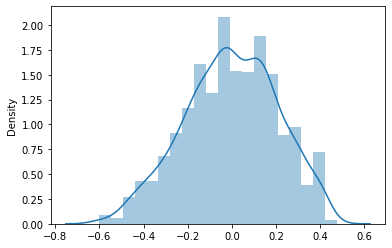

In [ ]:
y_pred = results.predict(x_test)
residual = y_test - y_pred
sns.distplot(residual)

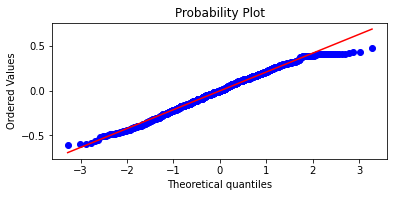

In [ ]:
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)

### Homoscedasticity

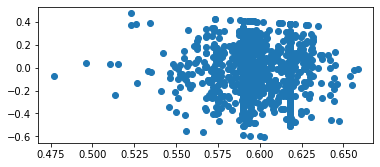

In [ ]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

### Autocorrelation of residuals  


<ipython-input-18-0550fce94d67>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


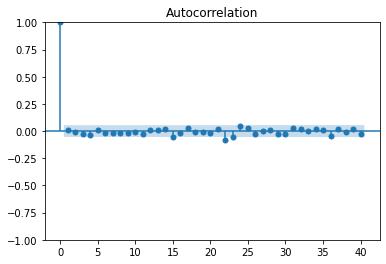

In [ ]:
acf = smt.graphics.plot_acf(residual, lags=40, alpha=0.05)
acf.show()

In [ ]:
# x = ibm.loc[:, ["positive_unmasked", "negative_unmasked", "storytelling_mixed_domain", "global_abs_hedge", "final_hedge"]]
# formula = "rank ~ C(negative_unmasked) * C(storytelling_mixed_domain) + C(negative_unmasked) * C(positive_unmasked) + global_abs_hedge + final_hedge"

# 4. Multilinear Regression with all Features

In [10]:
all_feats = ["rank", "prob_storytelling_mixed_domain", "global_abs_hedge"] + emotion_masked_prob[1:]
# all_feats = ["rank", "prob_storytelling_one_domain", "avg_hedge"] + emotion_masked_prob

all_multi_result = forward_selection(ibm[all_feats], "rank")
all_multi_model = all_multi_result["model"]
print(all_multi_model.summary())
print("Remaining IVs:", all_multi_result["remaining"])
multi_r2 = list(map(lambda x: x*100, all_multi_result["r2"]))
multi_sign = all_multi_result["significance"]

multi_names = map(re_feats,list(all_multi_model.params.index)[1:len(multi_r2)+1])
r_list = pd.DataFrame(list(zip(multi_names, multi_r2, multi_sign)), columns=("\\textbf{IVs}", "\\textbf{adj. \\textit{r}\\textsuperscript{2}}", "\\textbf{sign.}"))
print(r_list.to_latex(float_format="%.4f",index=False))

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     18.21
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           3.47e-33
Time:                        10:29:38   Log-Likelihood:                 924.38
No. Observations:                5298   AIC:                            -1827.
Df Residuals:                    5287   BIC:                            -1754.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [ ]:
all_feats = ["rank", "prob_storytelling_mixed_domain", "global_abs_hedge"] + emotion_masked_prob[1:]
# all_feats = ["rank", "prob_storytelling_one_domain", "avg_hedge"] + emotion_masked_prob

all_multi_result = forward_selection(ibm[all_feats], "rank")
all_multi_model = all_multi_result["model"]
print(all_multi_model.summary())
print("Remaining IVs:", all_multi_result["remaining"])
multi_r2 = list(map(lambda x: x*100, all_multi_result["r2"]))
multi_sign = all_multi_result["significance"]

multi_names = map(re_feats,list(all_multi_model.params.index)[1:len(multi_r2)+1])
r_list = pd.DataFrame(list(zip(multi_names, multi_r2, multi_sign)), columns=("\\textbf{IVs}", "\\textbf{adj. \\textit{r}\\textsuperscript{2}}", "\\textbf{sign.}"))
print(r_list.to_latex(float_format="%.4f",index=False))

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     18.21
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           3.47e-33
Time:                        10:29:38   Log-Likelihood:                 924.38
No. Observations:                5298   AIC:                            -1827.
Df Residuals:                    5287   BIC:                            -1754.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Intercept                         0.000000e+00
prob_guilt_shame_masked           6.136725e-08
prob_storytelling_mixed_domain    5.251219e-09
prob_sadness_masked               1.969045e-06
prob_joy_masked                   1.683013e-11
prob_fear_masked                  2.461627e-09
first_abs_hedge                   1.602641e-03
prob_disgust_masked               9.580716e-03
prob_relief_masked                2.023123e-02
Name: P-value, dtype: float64


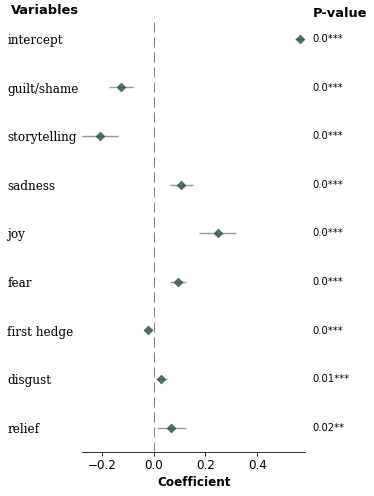

In [47]:
multi_params = all_multi_model.params
multi_conf = all_multi_model.conf_int()
multi_conf['Effect'] = multi_params
multi_conf.columns = ['5%', '95%', 'Effect']
multi_conf["Variables"] = [list(multi_params.index)[0].lower()] + [re_feats(x) for x in list(multi_params.index)[1:]]
multi_conf["P-value"] = all_multi_model.pvalues

fp.forestplot(multi_conf,  # the dataframe with results data
              estimate="Effect",  # col containing estimated effect size 
              ll="5%", hl="95%",  # columns containing conf. int. lower and higher limits
              varlabel="Variables",  # column containing variable label
              ylabel="Variables",  # y-label title
              xlabel="Coefficient",  # x-label title
              pval="P-value",  # column containing p-values
              ci_report=False,  # Turn off conf. int. reporting
              # xticks=[-.5,-.25,0,.25,.5],  # x-ticks to be printed
              # table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                 'fontfamily': 'serif'  # revert to sans-serif
                } 
              )

plt.savefig("img/ibm_all_forestplot.svg", bbox_inches="tight", format="svg")
print(multi_conf["P-value"])

### Testing for multicolinearity

In [48]:
v = ibm[list(all_multi_model.params.index)[1:]]
vif_data = pd.DataFrame() 
vif_data["feature"] = list(map(re_feats, v.columns))
vif_data["VIF"] = [variance_inflation_factor(v.values, i) for i in range(len(v.columns))]
# vif_data.sort_values("VIF",inplace=True)
print("Full variable set:")
print(vif_data.to_latex(float_format="%.4f",index=False))

Full variable set:
\begin{tabular}{lr}
\toprule
feature & VIF \\
\midrule
guilt/shame & 2.5607 \\
storytelling & 1.0512 \\
sadness & 2.2549 \\
joy & 1.2971 \\
fear & 1.6143 \\
first hedge & 3.5506 \\
disgust & 3.3231 \\
relief & 1.4572 \\
\bottomrule
\end{tabular}



# Full model

In [11]:
all_poly_result = poly_forward_selection(ibm[all_feats], "rank")
all_poly_model = all_poly_result["model"]
print(all_poly_model.summary())
print(all_poly_result["remaining"])

all_poly_r2 = list(map(lambda x: x*100, all_poly_result["r2"]))
all_poly_sign = all_poly_result["significance"]

all_poly_names = map(re_feats,list(all_poly_model.params.index)[1:len(all_poly_r2)+1])
r_list = pd.DataFrame(list(zip(all_poly_names, all_poly_r2, all_poly_sign)), columns=("\\textbf{IVs}", "\\textbf{adjusted \\textit{r}\\textsuperscript{2}}", "\\textbf{sign.}"))
print(r_list.to_latex(float_format="%.3f",index=False))

                            OLS Regression Results                            
Dep. Variable:                   rank   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     19.21
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           1.46e-41
Time:                        13:02:29   Log-Likelihood:                 947.77
No. Observations:                5298   AIC:                            -1870.
Df Residuals:                    5285   BIC:                            -1784.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

Intercept                                                 0.000000e+00
first_abs_hedge:prob_guilt_shame_masked                   1.080709e-10
prob_storytelling_mixed_domain                            7.647092e-07
prob_fear_masked:prob_guilt_shame_masked                  1.130815e-01
prob_joy_masked                                           2.250048e-11
prob_disgust_masked:prob_sadness_masked                   2.922571e-01
prob_pride_masked:prob_sadness_masked                     5.180805e-02
prob_pride_masked:prob_storytelling_mixed_domain          8.489212e-03
prob_pride_masked:prob_relief_masked                      3.409461e-04
first_abs_hedge:prob_pride_masked                         2.194053e-02
prob_disgust_masked:prob_fear_masked                      3.039887e-03
prob_guilt_shame_masked:prob_storytelling_mixed_domain    2.777254e-02
prob_sadness_masked                                       2.805629e-02
Name: P-value, dtype: float64


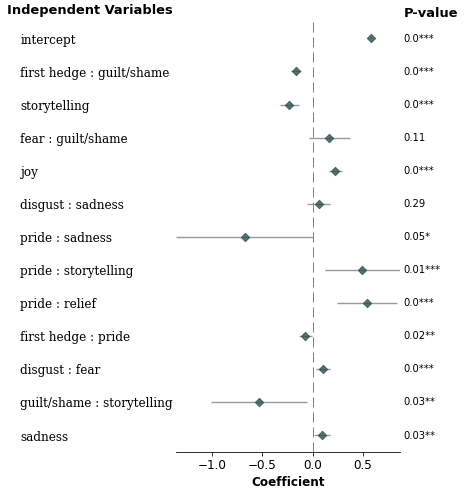

In [51]:
all_poly_params = all_poly_model.params
all_poly_conf = all_poly_model.conf_int()
all_poly_conf['Effect'] = all_poly_params
all_poly_conf.columns = ['5%', '95%', 'Effect']
all_poly_conf["Variables"] = ["intercept"] + [re_feats(x) for x in list(all_poly_params.index)[1:]]
all_poly_conf["P-value"] = all_poly_model.pvalues

fp.forestplot(all_poly_conf,  # the dataframe with results data
              estimate="Effect",  # col containing estimated effect size 
              ll="5%", hl="95%",  # columns containing conf. int. lower and higher limits
              varlabel="Variables",  # column containing variable label
              ylabel="Independent Variables",
              # ylabel="Coef(95% Conf. Int.)",  # y-label title
              xlabel="Coefficient",  # x-label title
              pval="P-value",  # column containing p-values
              ci_report=False,  # Turn off conf. int. reporting
              # xticks=[-7.5,-5,-2.5,0,2.5],  # x-ticks to be printed
              # table=True,  # Format as a table
              # Additional kwargs for customizations
              **{"marker": "D",  # set maker symbol as diamond
                 "markersize": 35,  # adjust marker size
                 "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
                 "xlinecolor": "#808080",  # gray color for x-reference line
                 "xtick_size": 12,  # adjust x-ticker fontsize
                 'fontfamily': 'serif'  # revert to sans-serif
                } 
              )

plt.savefig("img/ibm_all_inter_forestplot.svg", bbox_inches="tight", format="svg")
print(all_poly_conf["P-value"])

In [52]:
m = all_poly_result["model"]
i_m = list(m.params.index)
p_m = m.pvalues
x = [i for i in i_m if p_m[i] < 0.05]
x


['Intercept',
 'first_abs_hedge:prob_guilt_shame_masked',
 'prob_storytelling_mixed_domain',
 'prob_joy_masked',
 'prob_pride_masked:prob_storytelling_mixed_domain',
 'prob_pride_masked:prob_relief_masked',
 'first_abs_hedge:prob_pride_masked',
 'prob_disgust_masked:prob_fear_masked',
 'prob_guilt_shame_masked:prob_storytelling_mixed_domain',
 'prob_sadness_masked']

# Regression plots

In [56]:
def get_interaction_effect(interaction: str):
    inter_model = ols("rank ~"+interaction, ibm).fit()
    iv_1 = pd.Series(ibm[interaction.split(":")[0]], name = re_feats(ibm[interaction.split(":")[0]].name))
    tmp = np.log(ibm[interaction.split(":")[1]]) 
    iv_2 = []
    for instance in tmp:
        if instance <= tmp.mean()-tmp.std():
            iv_2.append("- 1 SD")
        elif instance <= tmp.mean()+tmp.std():
            iv_2.append("MEAN")
        elif instance <= tmp.mean()+2*tmp.std():
            iv_2.append("+ 1 SD")
        else:
            iv_2.append("+ 2 SD")
    hue_order = ["+ 2 SD", "+ 1 SD", "MEAN", "- 1 SD"]
    iv_2 = pd.Series(iv_2,name=re_feats(tmp.name))
    dv = pd.Series(inter_model.fittedvalues, name="argument quality")
    df = pd.concat((iv_1, iv_2, dv), axis=1)
    sns.relplot(
        data=df, kind="line", 
        x=iv_1.name, y="argument quality", 
        hue=iv_2.name, style=iv_2.name,
        hue_order=hue_order, 
        palette="mako" # mako plasma crest inferno
    )

def get_individual_effect(iv: str, num: (int,int)):
    if num[1] < 6:
        color = sns.color_palette("mako").as_hex()[num[0]+1]
    elif num[1] > 6:
        color = sns.color_palette("mako", n_colors=num[1]).as_hex()[num[0]]
    else:
        color = sns.color_palette("mako").as_hex()[num[0]]
    output = sns.regplot(data=ibm, x=iv, y="rank", scatter=False, color=color)
    output.set(xlabel=re_feats(ibm[iv].name), ylabel="argument quality")
    plt.savefig(f"img/ibm_{iv}_forestplot.svg", bbox_inches="tight", format="svg")
    plt.show()

In [54]:
# get_individual_effect("prob_trust_masked")
sns.color_palette("mako")

[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

In [12]:
# sns.lmplot(data=ibm, x="prob_fear_masked", y="rank", hue="prob_sadness_masked", palette="mako", order=2, scatter=False)

## Interaction plots

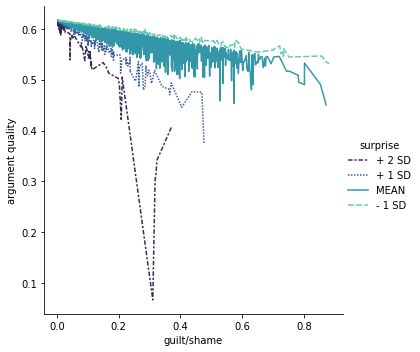

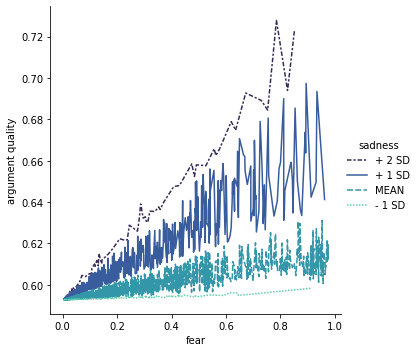

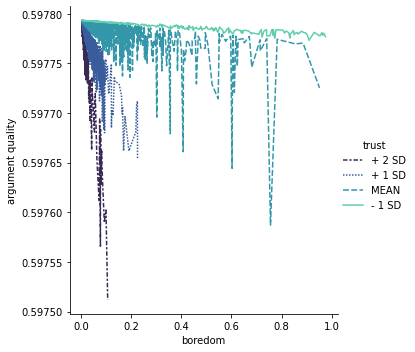

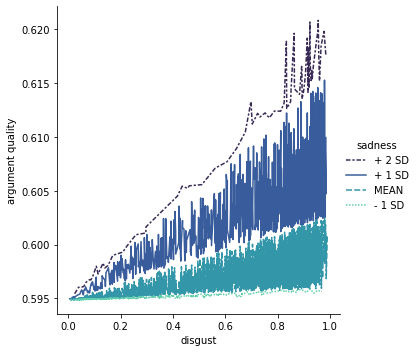

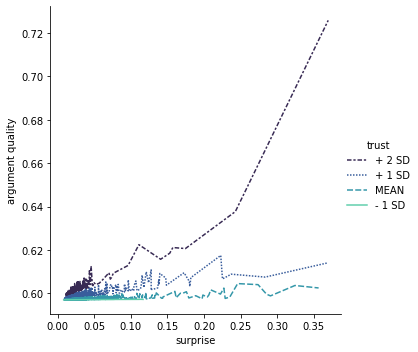

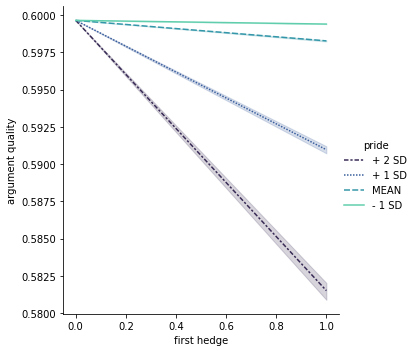

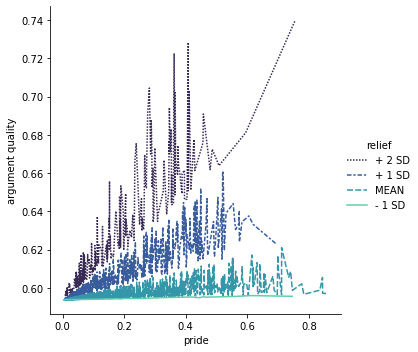

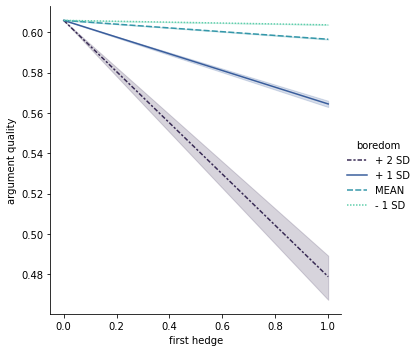

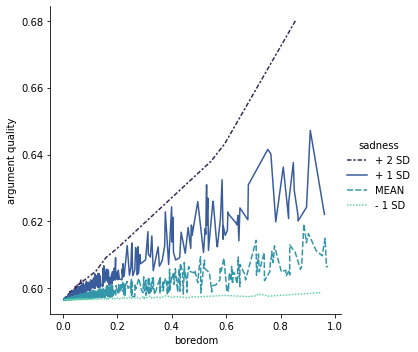

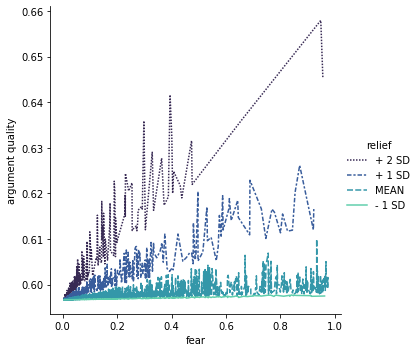

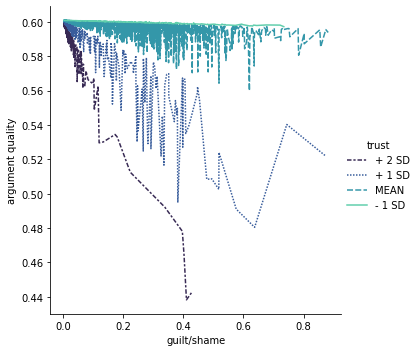

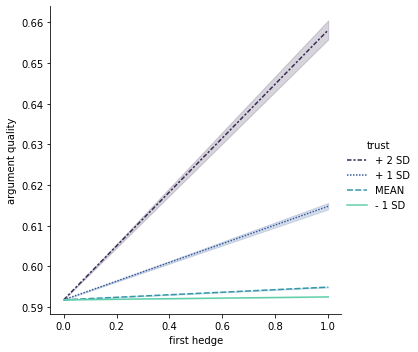

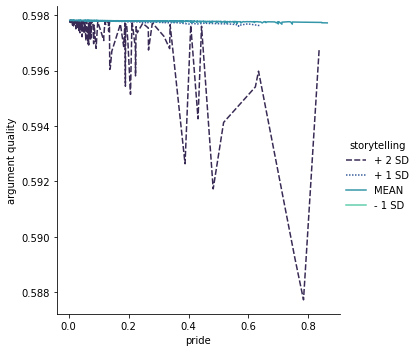

In [60]:
inter_ivs = []
for iv in list(all_poly_params.index)[1:]:
    if ":" in iv:
        inter_ivs.append(iv)
        get_interaction_effect(iv)

## Individual regression plots

### Hedging

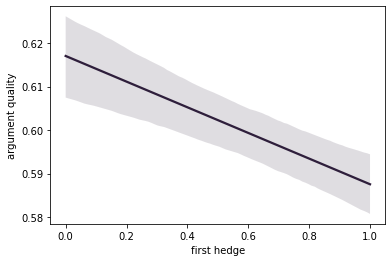

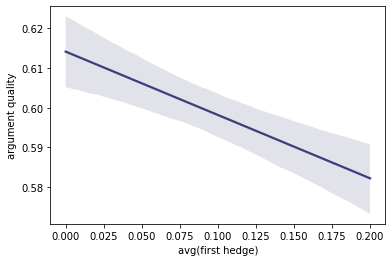

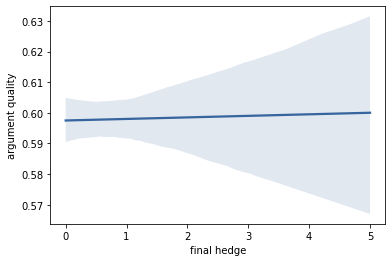

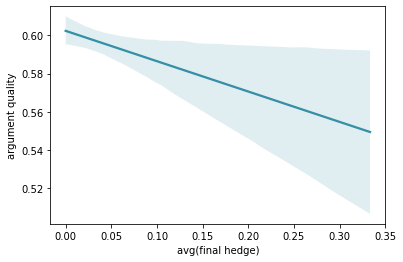

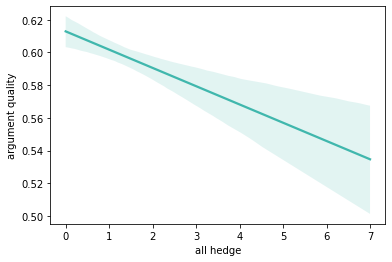

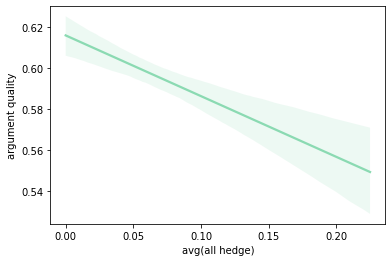

In [57]:
for i, iv in enumerate(hedging):
    get_individual_effect(iv, (i,6))
    

### Emotions

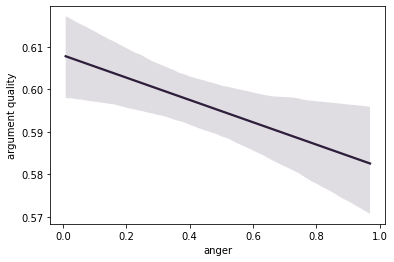

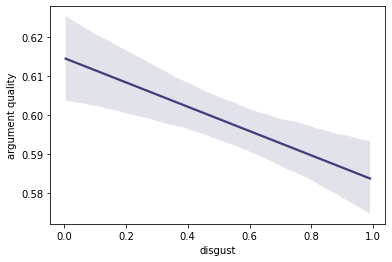

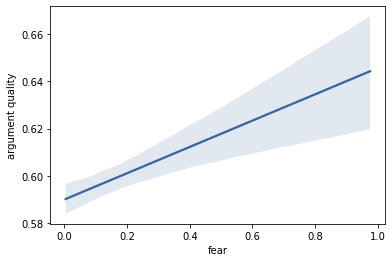

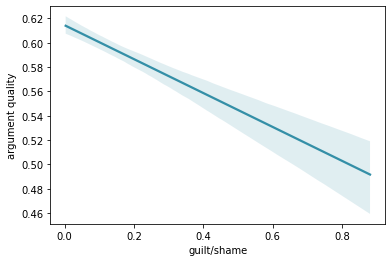

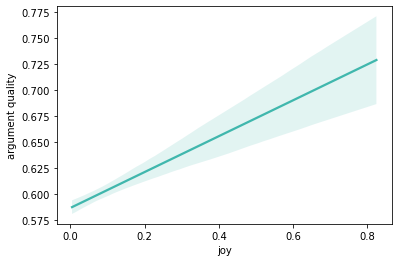

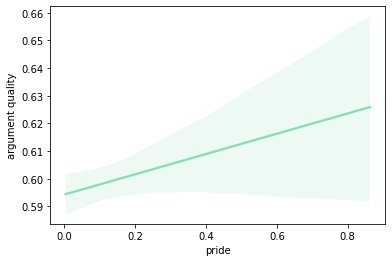

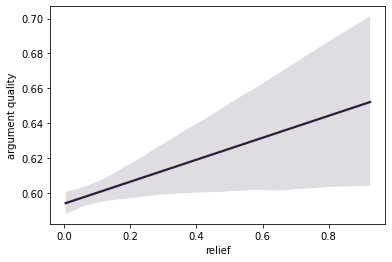

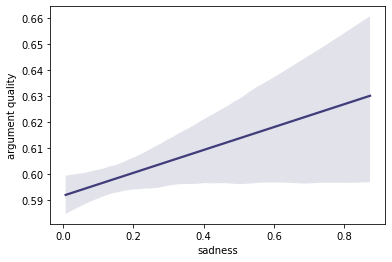

In [58]:
for i, iv in enumerate(emotion_masked_prob):
    get_individual_effect(iv, (i%6,6))

### Storytelling

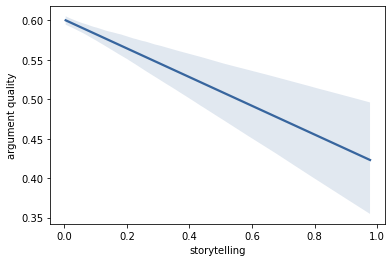

In [59]:
get_individual_effect("prob_storytelling_mixed_domain", (2,6))

In [60]:
def get_log_sds(iv: str):
    log = np.log(ibm[iv])
    mean = log.mean()
    std = log.std()
    print(f"-1SD: {np.exp(mean-std):.4f}, MEAN: {np.exp(mean):.4f}, \n+1SD: {np.exp(mean+std):.4f}, +2STD: {np.exp(mean+2*std):.4f}")
def get_sds(iv: str):
    mean = ibm[iv].mean()
    std = ibm[iv].std()
    print(f"-1SD: {mean-std:.4f}, MEAN: {mean:.4f}, \n+1SD: {mean+std:.4f}, +2STD: {mean+2*std:.4f}")

get_sds("prob_surprise_masked")

-1SD: 0.0022, MEAN: 0.0271, 
+1SD: 0.0520, +2STD: 0.0769
